Market Basket Analysis using Apriori and FP-Growth Algorithm

Problem Objective:
To optimize product recommendations, marketing strategies, and inventory management for Instacart's online grocery shopping platform by uncovering hidden patterns and associations within a large dataset of customer orders.

Specific objectives include:

Identifying high-frequency co-purchased product combinations:
#To recommend complementary or substitute products, increasing the average order value and improving customer satisfaction.
Segmenting customers based on purchasing behavior and demographics:
#To tailor marketing efforts and product offerings to specific customer segments, improving conversion rates and customer loyalty.
Analyzing purchase frequency and timing for different product categories:
#To optimize inventory management, anticipate demand fluctuations, and prevent stockouts or overstocking.
Understanding product substitution and complementarity relationships:
#To identify opportunities for cross-selling and upselling, increasing revenue per customer.
Gaining insights into customer preferences and trends:
#To inform future product development, assortment planning, and pricing strategies, ensuring that Instacart's offerings align with customer needs and preferences.

Data Exploration

In [2]:
#import the needed librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation


In [3]:
order_products_train = pd.read_csv(r'C:\Users\USER\Downloads\instacart-market-basket-analysis\order_products__train.csv')
order_products_prior = pd.read_csv(r'C:\Users\USER\Downloads\instacart-market-basket-analysis\order_products__prior.csv')
orders = pd.read_csv(r'C:\Users\USER\Downloads\instacart-market-basket-analysis\orders.csv')
products = pd.read_csv(r'C:\Users\USER\Downloads\instacart-market-basket-analysis\products.csv')
aisles = pd.read_csv(r'C:\Users\USER\Downloads\instacart-market-basket-analysis\aisles.csv\aisles.csv')
departments = pd.read_csv(r'C:\Users\USER\Downloads\instacart-market-basket-analysis\departments.csv')

In [4]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [5]:
#display first five rows.
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
#display first five rows. 
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [8]:
#display first five rows.
order_products_all.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
#missing value
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data


,Total Missing,Percent
order_id,0,0.0
product_id,0,0.0
add_to_cart_order,0,0.0
reordered,0,0.0


In [10]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


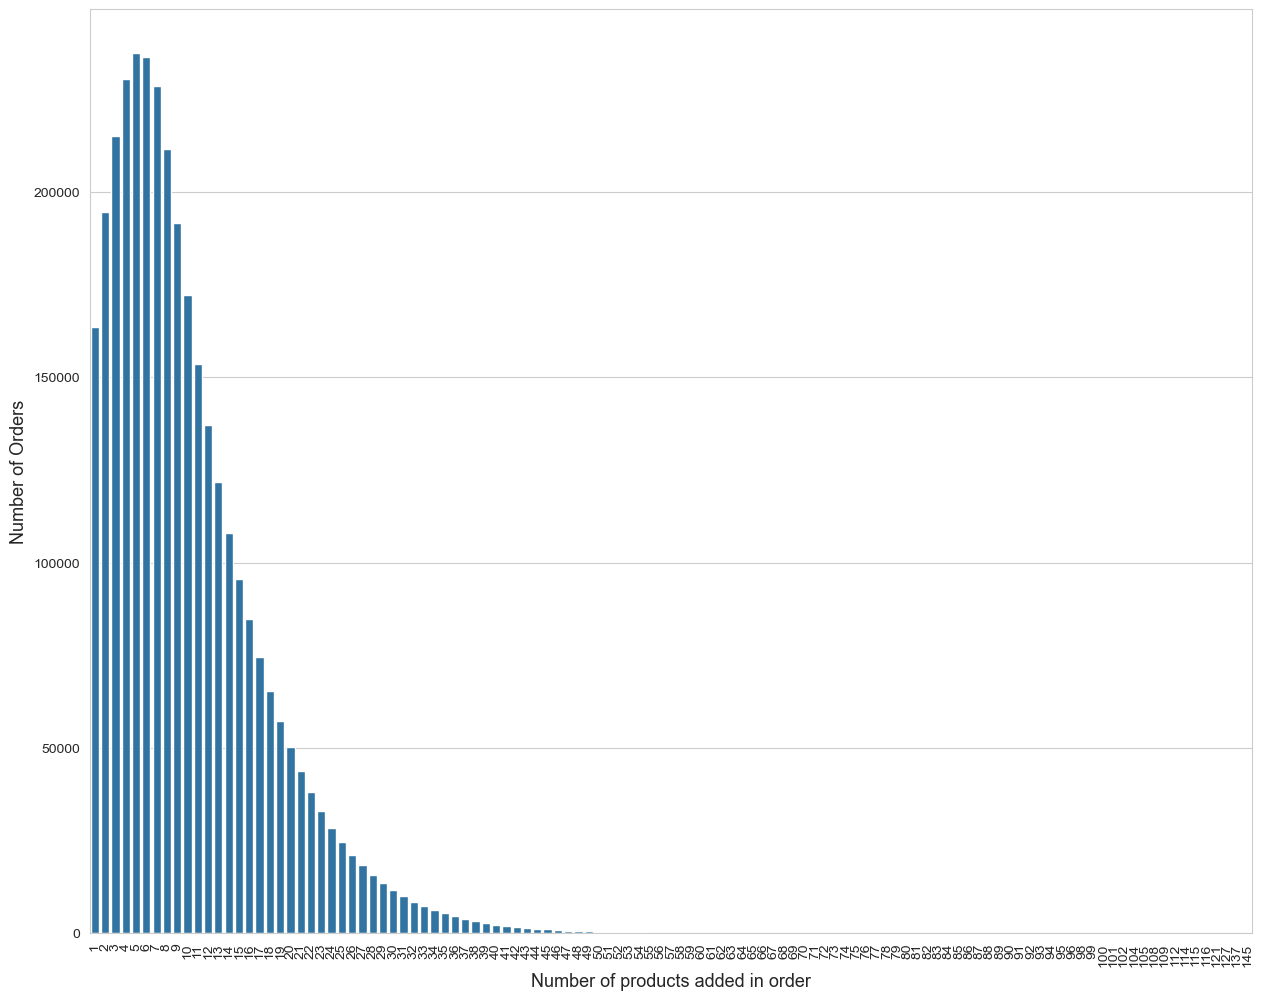

In [11]:
#Number of products that people usually order :
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index, y=grouped.values,ax=ax)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

We can observe that people usually order around 5 products.

In [85]:
#Most ordered Products
grouped = order_products_all.groupby("product_id").agg(Total_reorders=('reordered','count')).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
print(grouped)

       product_id  Total_reorders            product_name
24849       24852          491291                  Banana
13173       13176          394930  Bag of Organic Bananas
21134       21137          275577    Organic Strawberries
21900       21903          251705    Organic Baby Spinach
47205       47209          220877    Organic Hass Avocado
47762       47766          184224         Organic Avocado
47622       47626          160792             Large Lemon
16794       16797          149445            Strawberries
26206       26209          146660                   Limes
27842       27845          142813      Organic Whole Milk


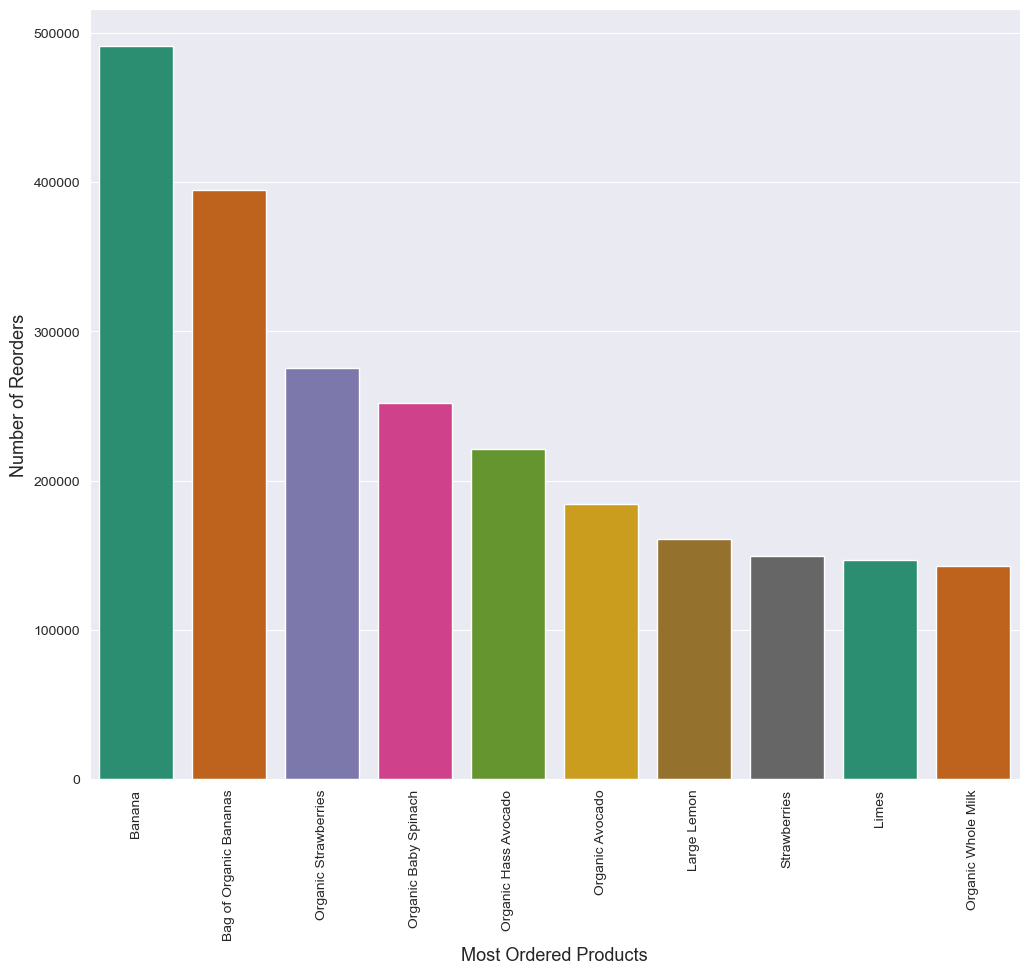

In [95]:
# Grouping by 'product_name' and summing 'Total_reorders'
grouped = grouped.groupby('product_name')['Total_reorders'].sum().reset_index()

# Sorting the values by 'Total_reorders' in descending order
grouped = grouped.sort_values(by='Total_reorders', ascending=False)

# Setting the seaborn style for the plot
sns.set_style('darkgrid')

# Creating the figure and axis
f, ax = plt.subplots(figsize=(12, 10))

# Rotating the x-ticks for better visibility
plt.xticks(rotation='vertical')

# Creating the bar plot
sns.barplot(x='product_name', y='Total_reorders', data=grouped, ax=ax, palette='Dark2')

# Adding labels to the axes
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most Ordered Products', fontsize=13)

# Display the plot
plt.show()


Fruits like banana , strawberries...are the most ordered products.

In [14]:
#Do people usually reorder the same previous ordered products ?
grouped = order_products_all.groupby("reordered").agg(Total_reorders=('reordered', 'count')).reset_index()

# Calculating the ratios based on Total_reorders
grouped['Ratios'] = grouped["Total_reorders"].apply(lambda x: x / grouped['Total_reorders'].sum())

grouped



,reordered,Total_reorders,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


59 % of ordered products are previously ordered by customers

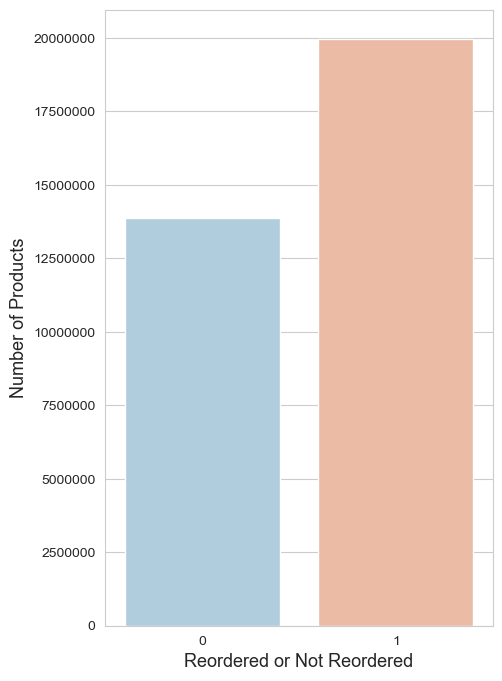

In [15]:
grouped= grouped.groupby(['reordered']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(x=grouped.index, y=grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [20]:
# Aggregating using a DataFrameGroupBy object
grouped = order_products_all.groupby("product_id").agg(
    reorder_sum=('reordered', 'sum'),
    reorder_total=('reordered', 'count')
).reset_index()

# Calculating the reorder probability
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']

# Merging with product names
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on='product_id')

# Filtering products with more than 75 total reorders and sorting by reorder probability
grouped = grouped[grouped['reorder_total'] > 75].sort_values(by='reorder_probability', ascending=False).head(10)

grouped


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


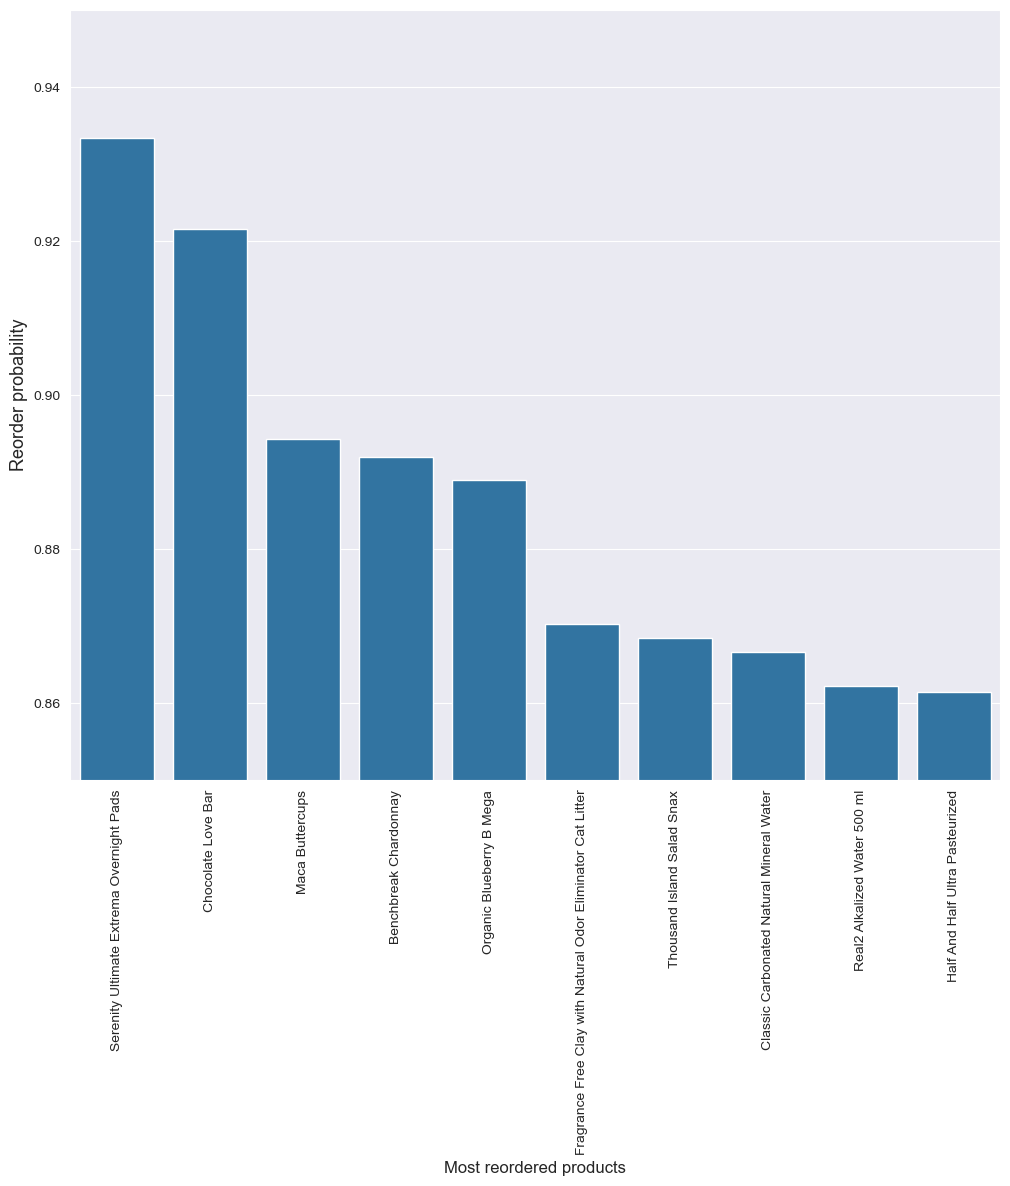

In [21]:
grouped = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index,y= grouped.values, ax=ax)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

In [22]:
print("The orders data size is : ", orders.shape)
print("Columns in orders data  are : ",  orders.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data  are :  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [23]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [24]:
#Missing Data
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

days_since_prior_order    6.027594
dtype: float64

The only feature with missing values is days_since_prior_order with 6.028 % missing

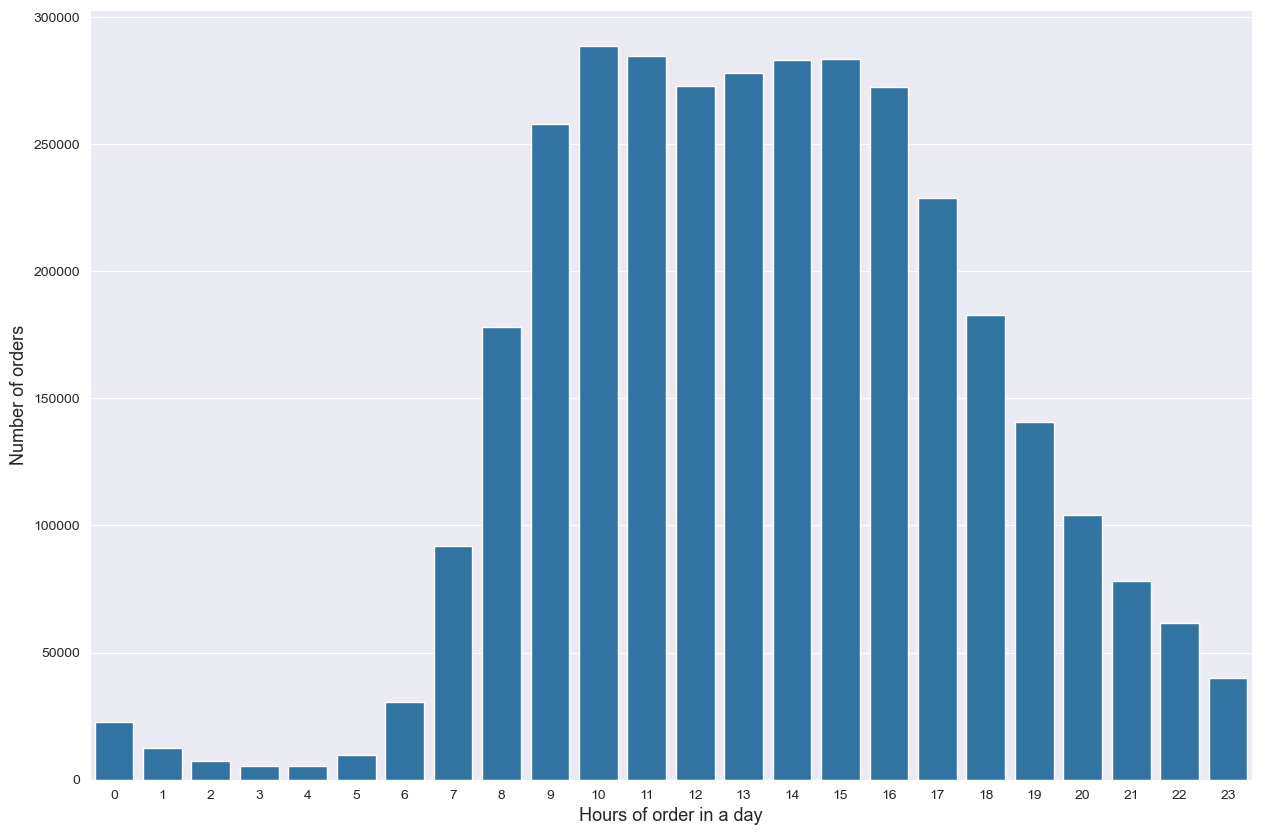

In [27]:
#Hours of Order in a Day:
grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=grouped.index, y=grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

People mostly order between 8 and 19 (anonimyzed hours and probably between 8 a.m and 7 p.m.)


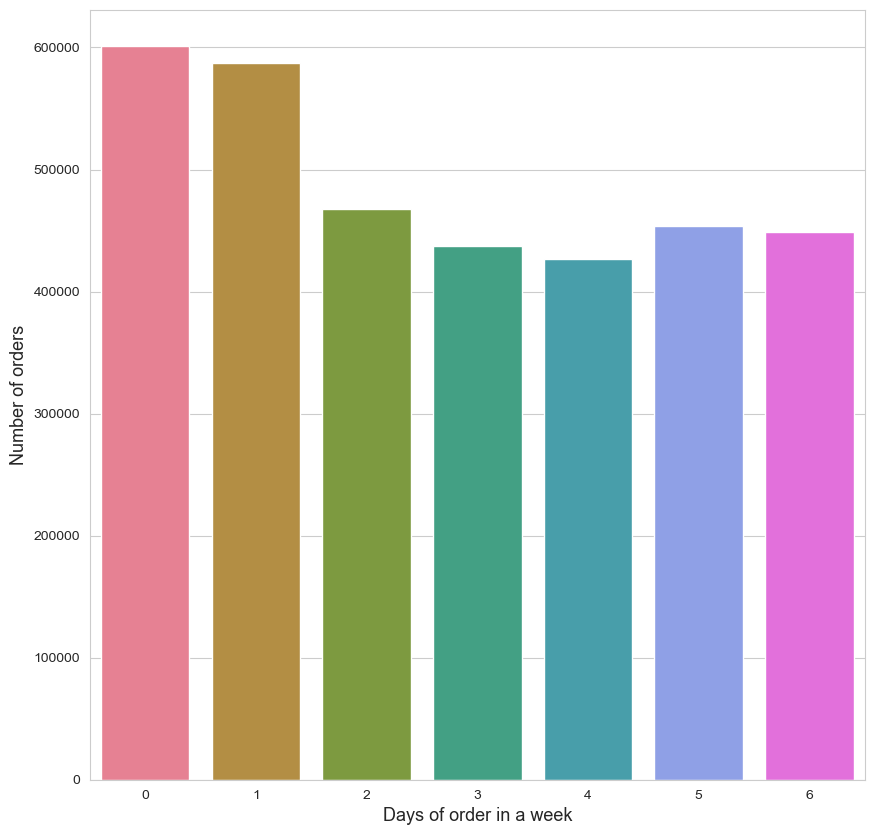

In [62]:
#Days of Orders in a week:

grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=grouped.index, y=grouped.values,palette='husl')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

People usually order at days 0 and 1 (anonimyzed days and probably the week end)

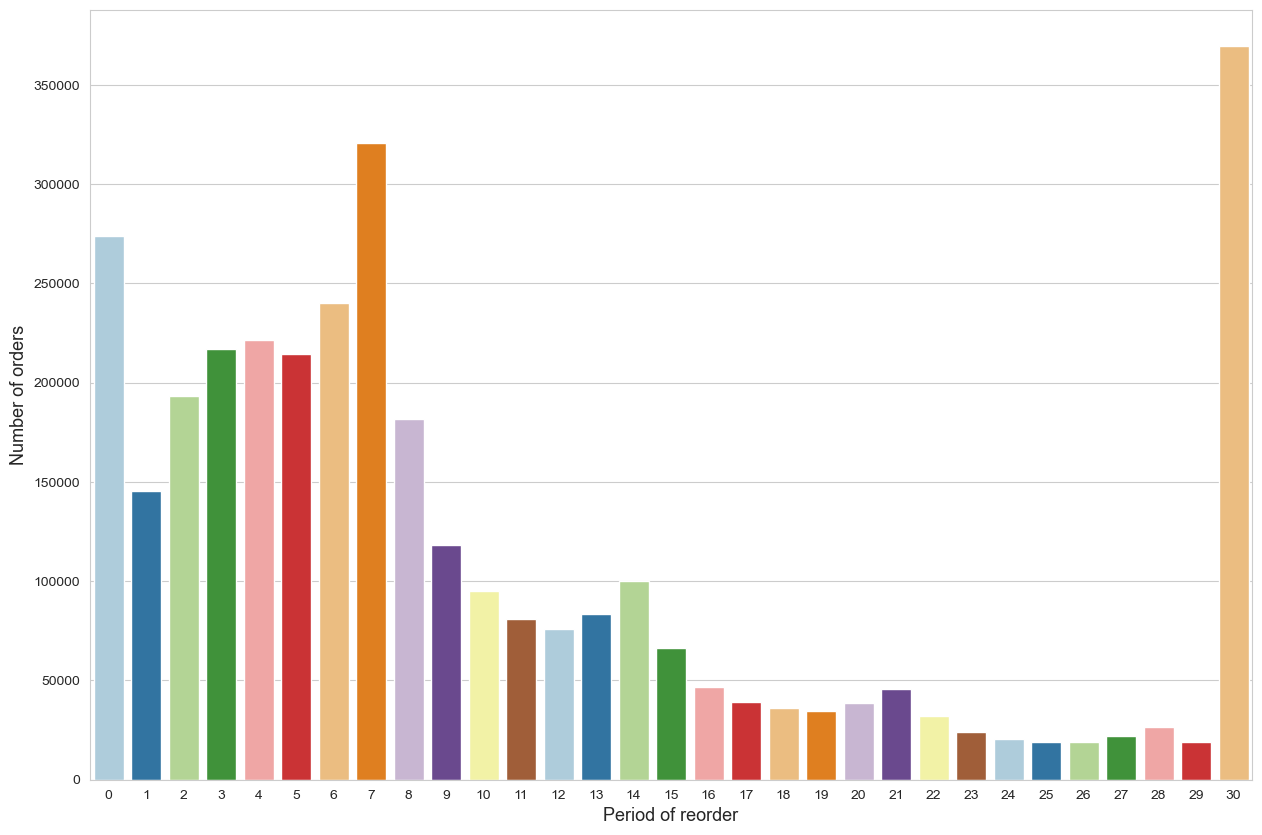

In [61]:
#Period of Reorders:

grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=grouped.index, y=grouped.values, palette='Paired')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

In [34]:
#Orders in the whole dataset¶
#Number and ratio of orders from the three datasets (prior, train, test).

grouped = orders.groupby("eval_set")["order_id"].agg(['count']).reset_index()
grouped = grouped.rename(columns={'count': 'Total_orders'})
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x / grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.939724
1,test,75000,0.021923
2,train,131209,0.038353


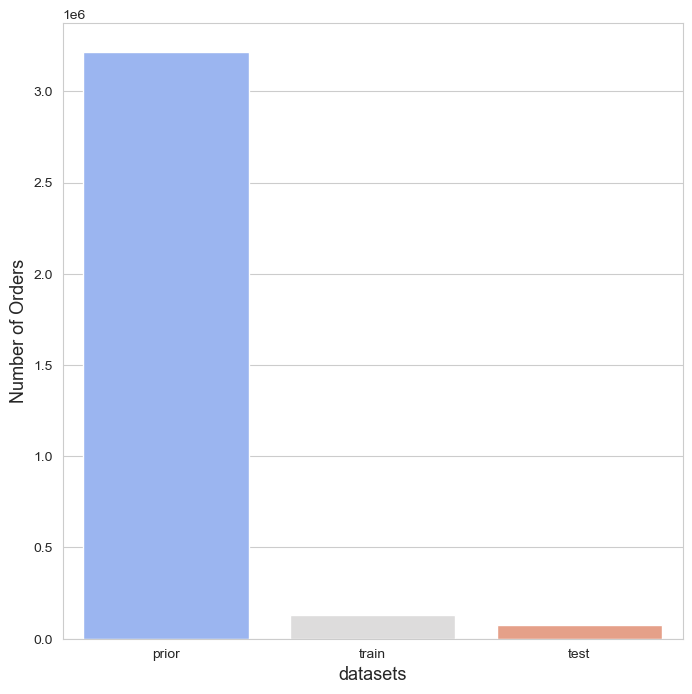

In [37]:
grouped  = grouped.groupby(['eval_set']).sum(['Total_orders']).sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=grouped.index, y=grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()


In [38]:
#Customers in the whole dataset¶
#the total number of unique customers in the three datasets (prior, train, test)
print("Number of unique customers in the whole dataset : ",len(set(orders.user_id)))

Number of unique customers in the whole dataset :  206209


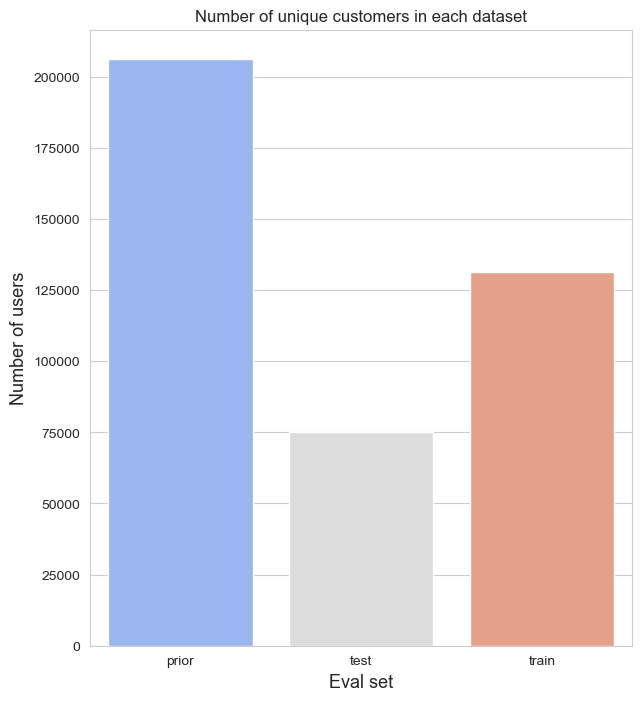

In [39]:
grouped = orders.groupby("eval_set")["user_id"].apply(lambda x: len(x.unique()))

plt.figure(figsize=(7,8))
sns.barplot(x=grouped.index,y= grouped.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Eval set', fontsize=13)
plt.title("Number of unique customers in each dataset")
plt.show()


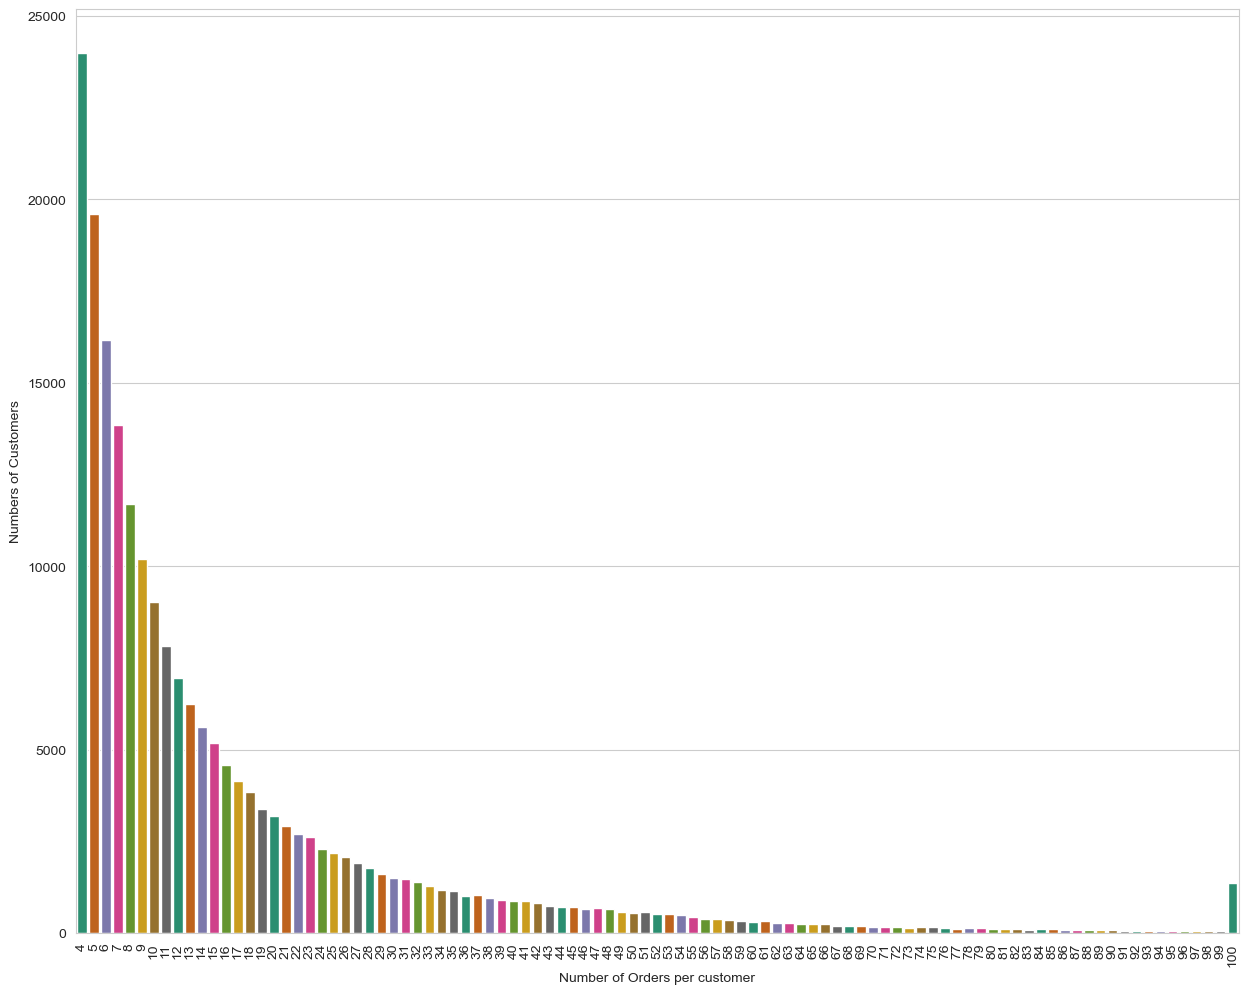

In [60]:
#Orders made by each customer
#the number of orders made by each costumer in the whole dataset
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(x=grouped.index,y= grouped.user_id,palette='Dark2')
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

We can observe that most customers made 4 orders.

In [43]:
#products
#display first five rows of our dataset.
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [44]:
#display first five rows of our dataset.
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [45]:
#display first five rows of our dataset.
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [46]:
#combine them in a single dataframe
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [48]:
#Most important Departments (by number of products)
grouped = items.groupby("department")["product_id"].agg(['count']).reset_index()
grouped = grouped.rename(columns={'count': 'Total_products'})
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x / grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132084
20,snacks,6264,0.126067
16,pantry,5371,0.108095
3,beverages,4365,0.087848
10,frozen,4007,0.080643
7,dairy eggs,3449,0.069413
11,household,3085,0.062087
6,canned goods,2092,0.042103
9,dry goods pasta,1858,0.037393
19,produce,1684,0.033891


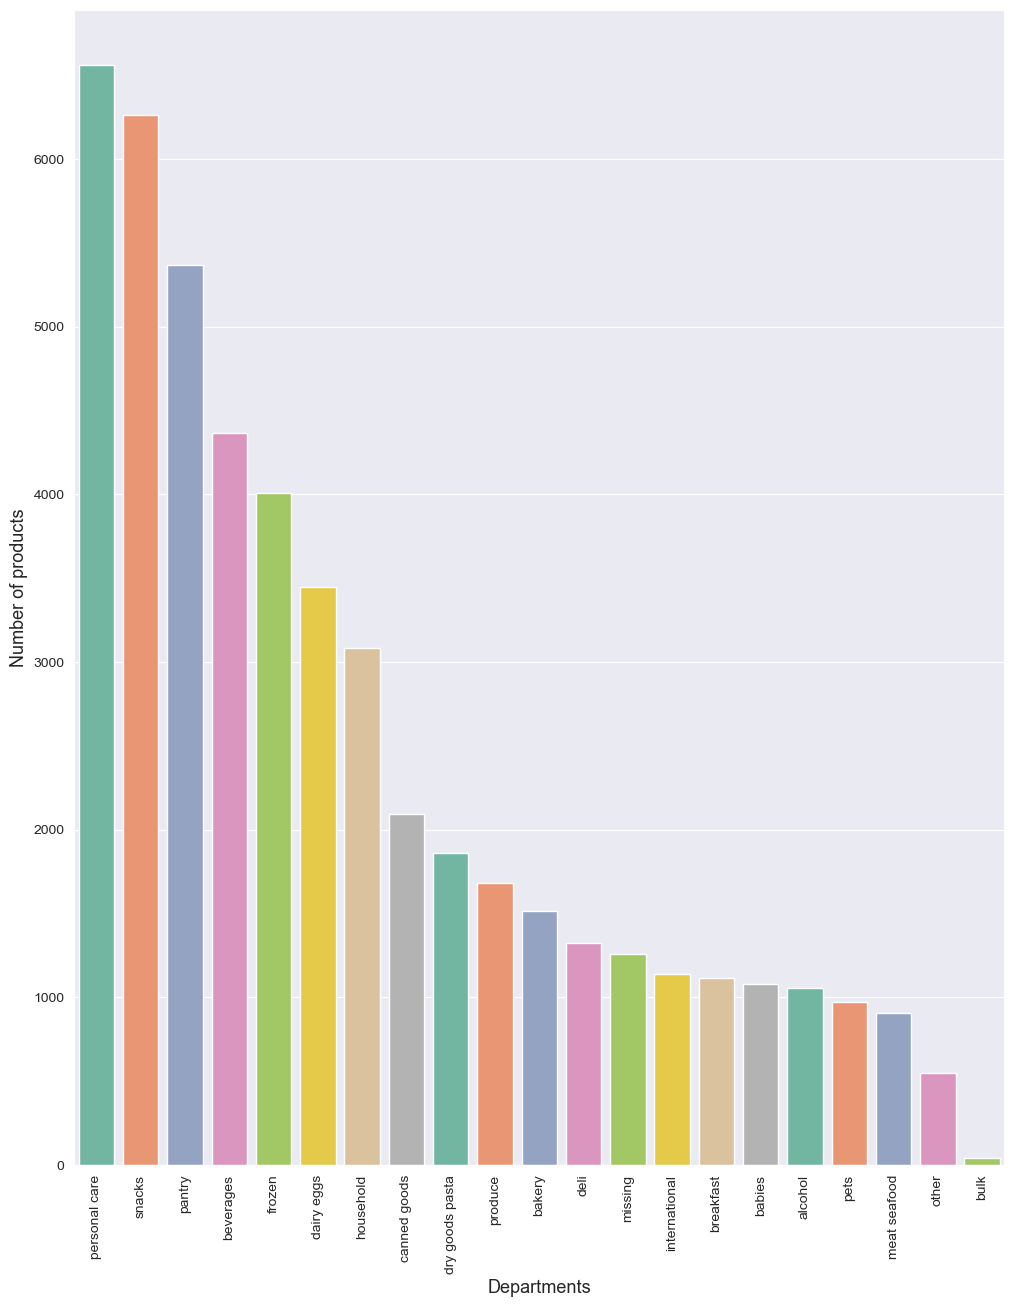

In [57]:
grouped  = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index,y= grouped.values,palette='Set2')
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()


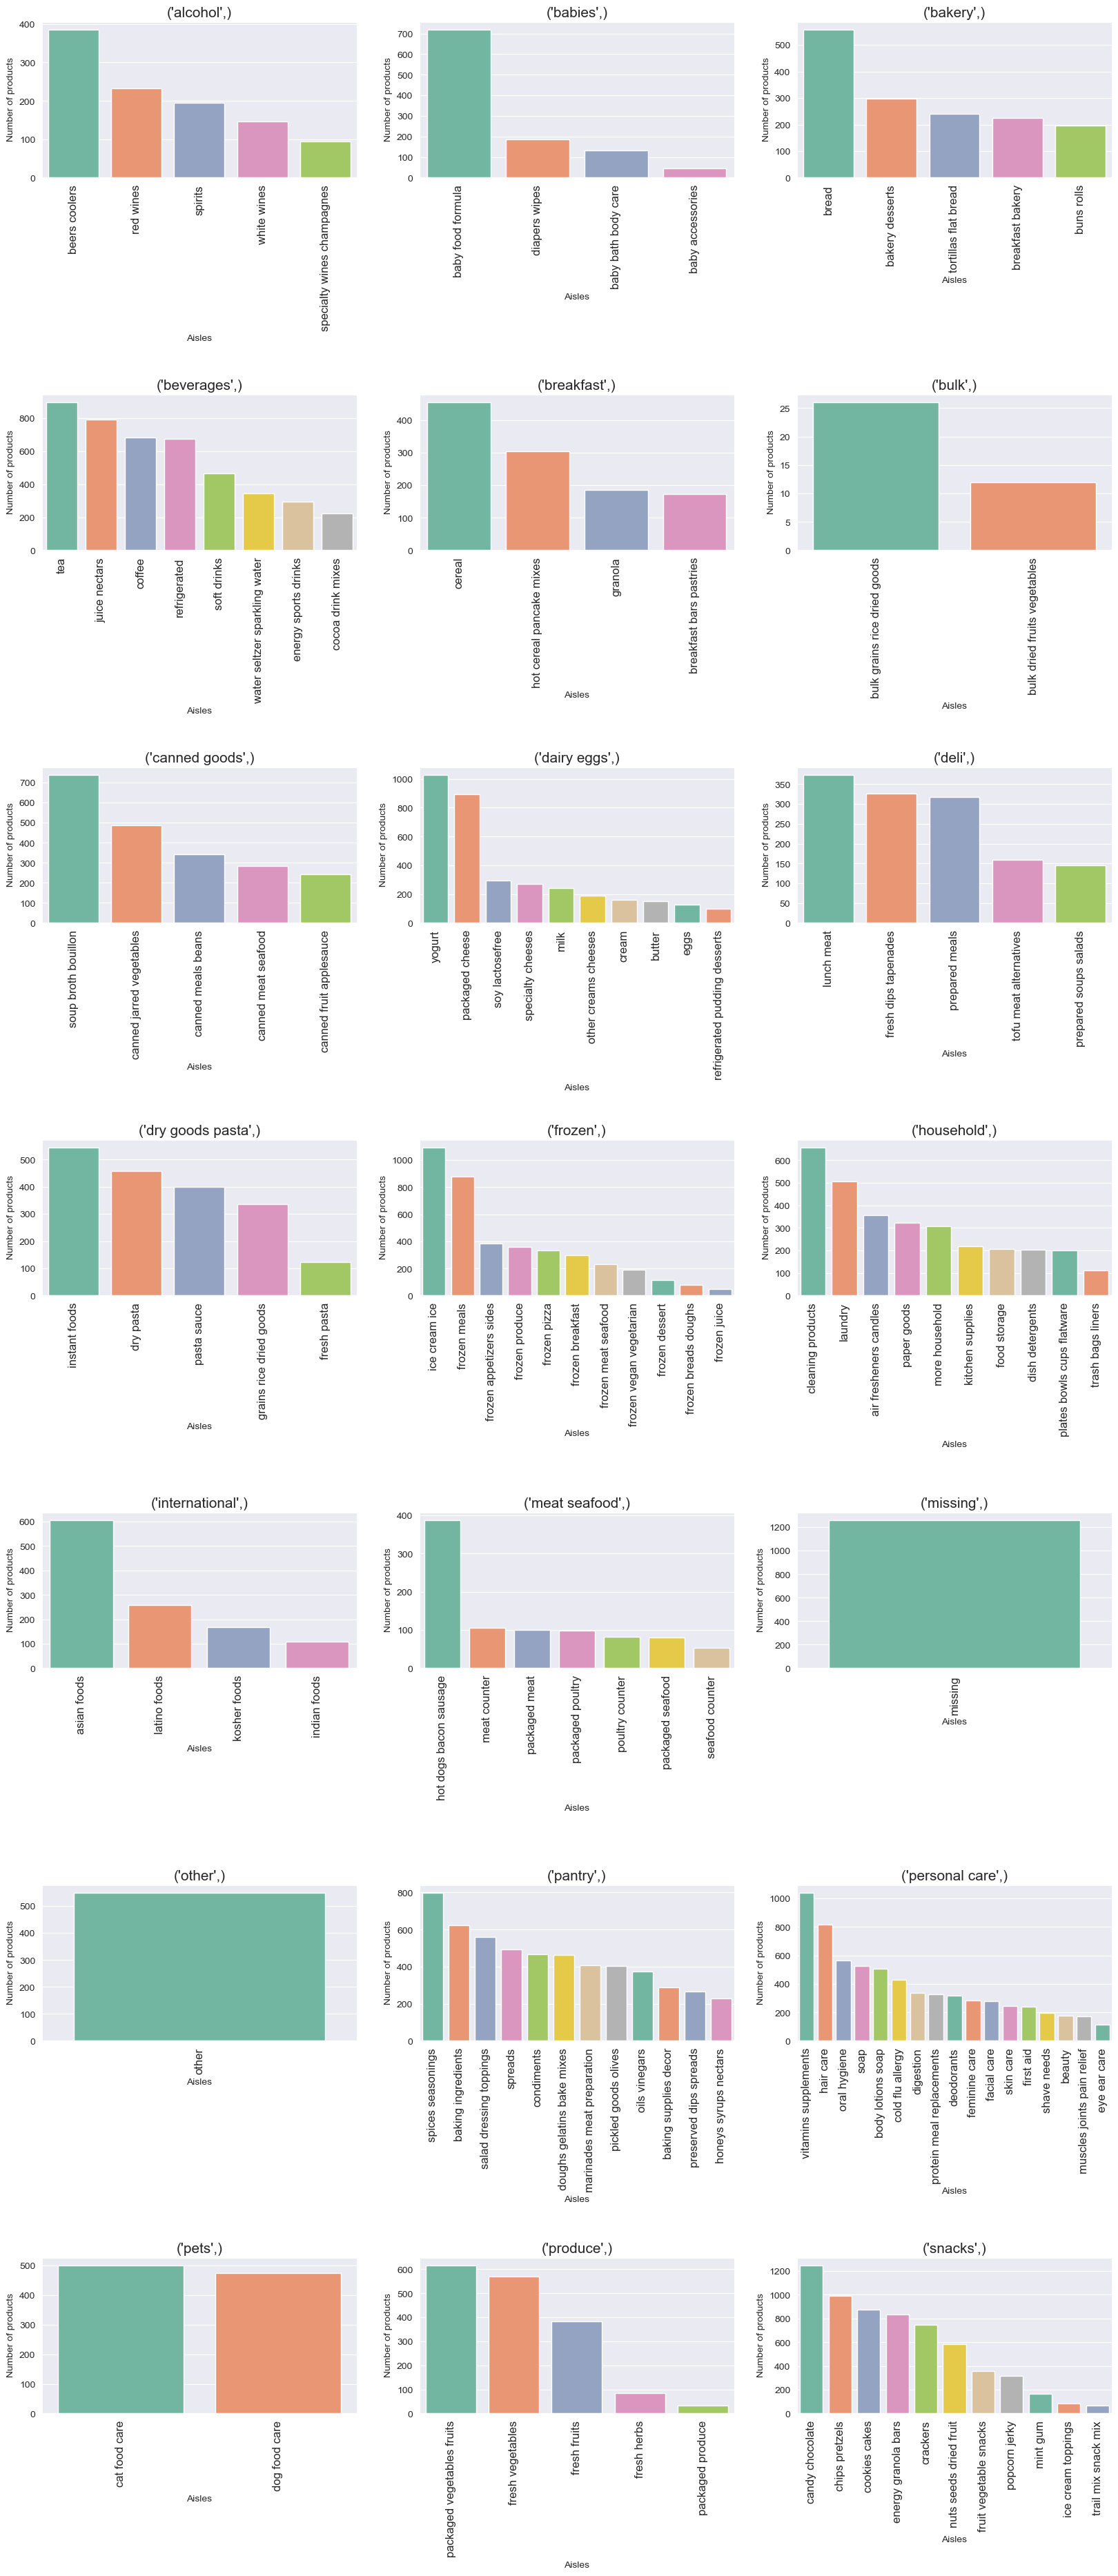

In [56]:
#Most important Aisles in each Department (by number of Products)¶
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate( ['count']).reset_index()
grouped = grouped.rename(columns={'count': 'Total_products'})
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(x=group.aisle, y=group.Total_products , ax=ax,palette='Set2')
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)


In [64]:
#Most important Aisles over all Departments (by number of Products)¶
grouped = items.groupby("aisle")["product_id"].aggregate(['count']).reset_index()
grouped = grouped.rename(columns={'count': 'Total_products'})
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025318
18,candy chocolate,1246,0.025076
71,ice cream ice,1091,0.021957
130,vitamins supplements,1038,0.020890
133,yogurt,1026,0.020649
25,chips pretzels,989,0.019904
125,tea,894,0.017992
93,packaged cheese,891,0.017932
59,frozen meals,880,0.017711
31,cookies cakes,874,0.017590


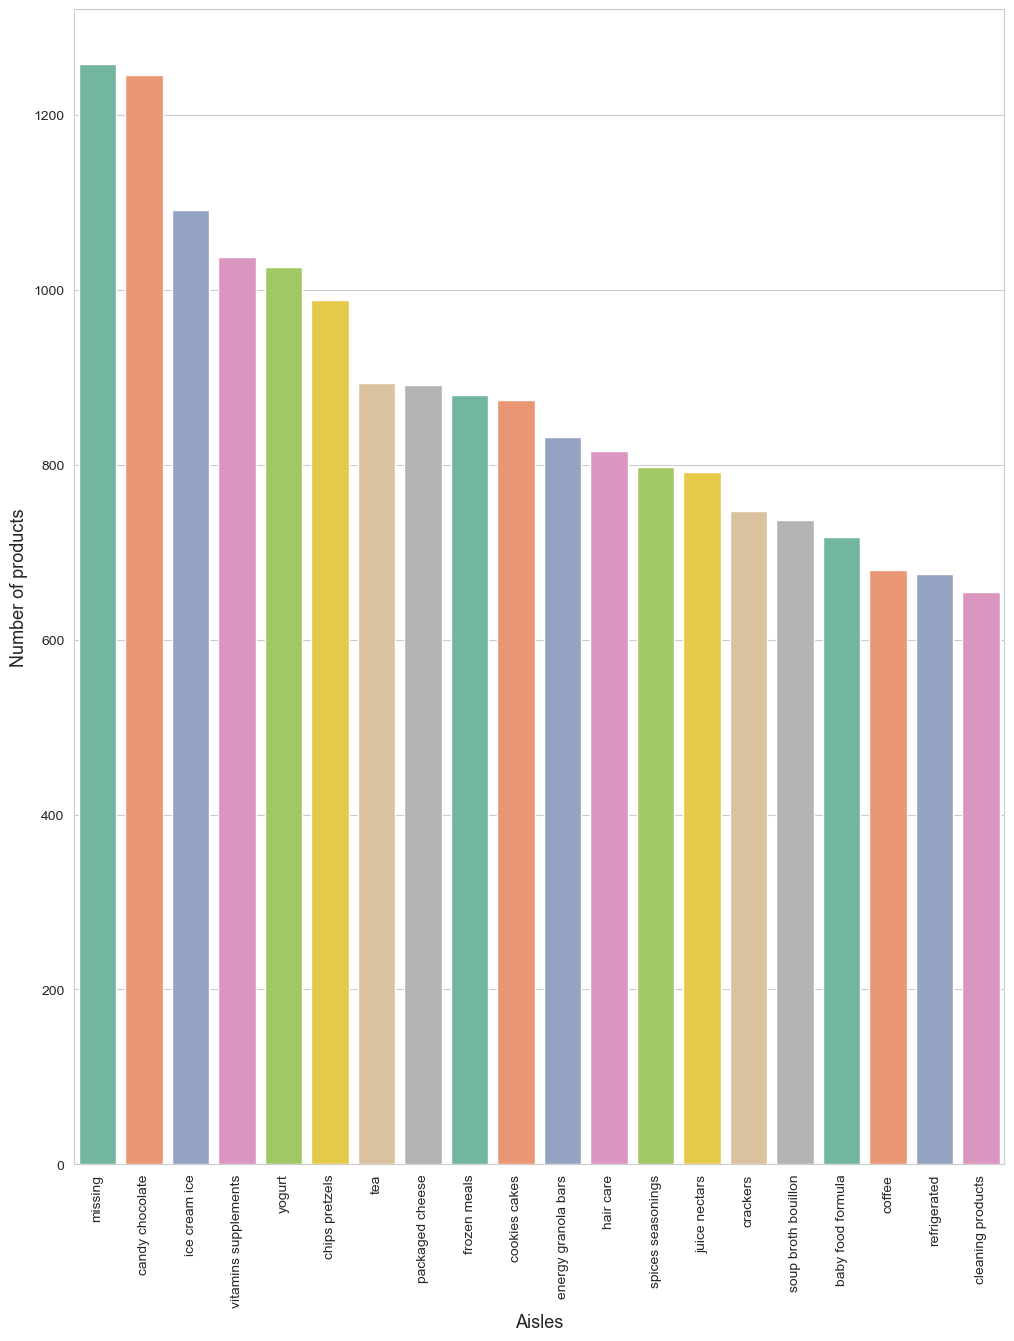

In [68]:
grouped  = grouped.groupby(['aisle']).sum(['Total_products']).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index, y=grouped.values,palette='Set2')
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

In [70]:
#What are customers' favorite Departments and Aisles ?

users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')
users_flow

,user_id,order_id,product_id,product_name,aisle_id,department_id,department,aisle
0,1,1187899,196,Soda,77,7,beverages,soft drinks
1,1,1187899,25133,Organic String Cheese,21,16,dairy eggs,packaged cheese
2,1,1187899,38928,0% Greek Strained Yogurt,120,16,dairy eggs,yogurt
3,1,1187899,26405,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods
4,1,1187899,39657,Milk Chocolate Almonds,45,19,snacks,candy chocolate
...,...,...,...,...,...,...,...,...
1384612,206209,272231,40603,Fabric Softener Sheets,75,17,household,laundry
1384613,206209,272231,15655,Dark Chocolate Mint Snacking Chocolate,45,19,snacks,candy chocolate
1384614,206209,272231,42606,Phish Food Frozen Yogurt,37,1,frozen,ice cream ice
1384615,206209,272231,37966,French Baguette Bread,112,3,bakery,bread


In [75]:
#Best Selling Departments (number of Orders)¶
grouped = users_flow.groupby("department")["order_id"].aggregate(['count']).reset_index()
grouped = grouped.rename(columns={'count': 'Total_orders'})
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped


,department,Total_orders,Ratio
19,produce,409087,0.295451
7,dairy eggs,217051,0.156759
20,snacks,118862,0.085845
3,beverages,114046,0.082366
10,frozen,100426,0.072530
16,pantry,81242,0.058675
2,bakery,48394,0.034951
6,canned goods,46799,0.033799
8,deli,44291,0.031988
9,dry goods pasta,38713,0.027959


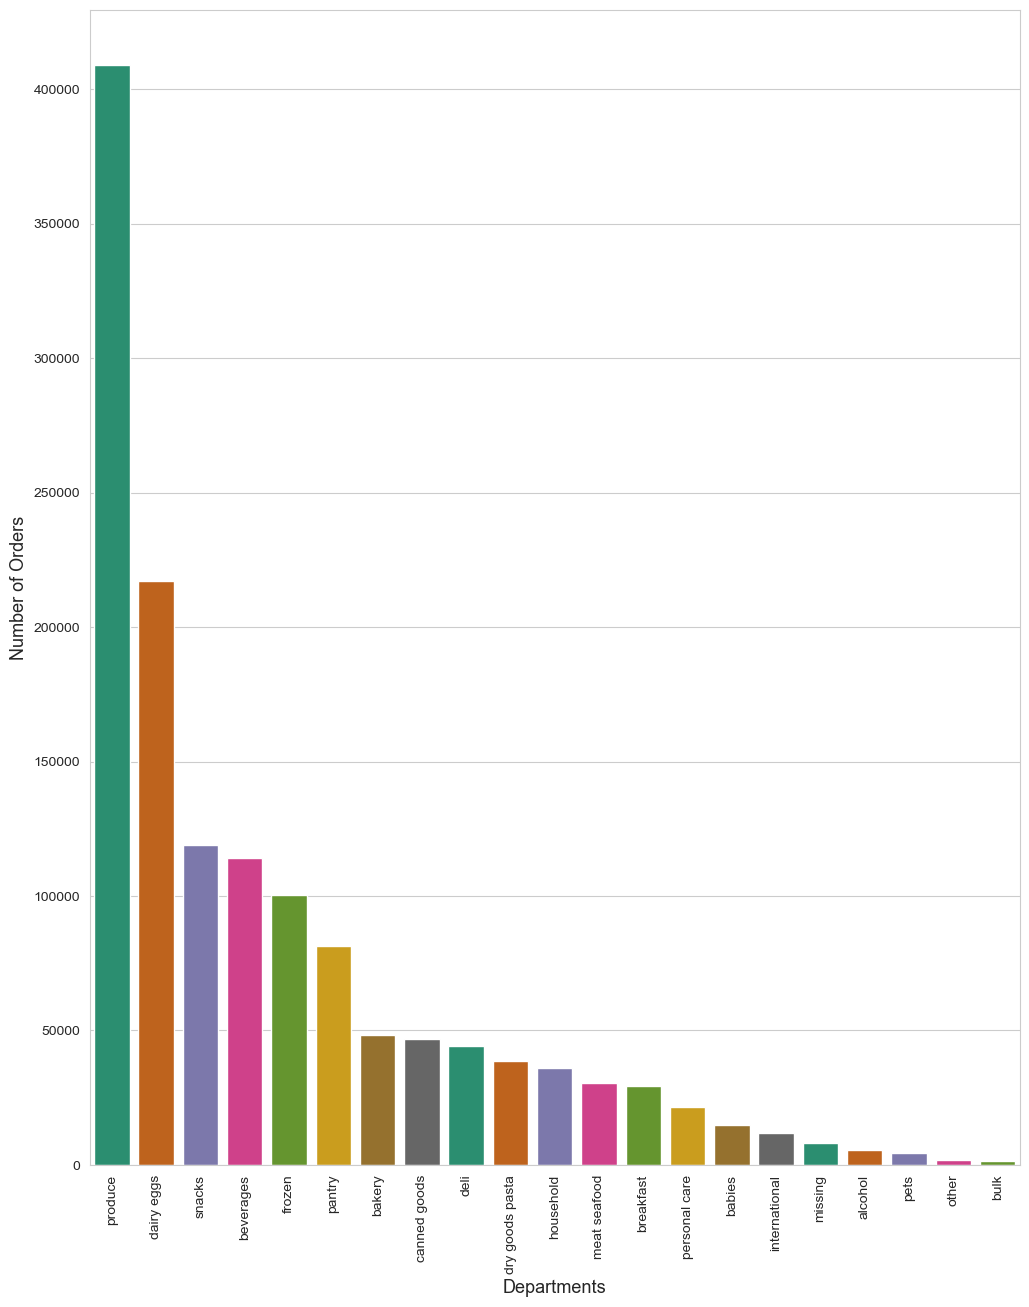

In [76]:
grouped  = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index, y=grouped.values,palette='Dark2')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

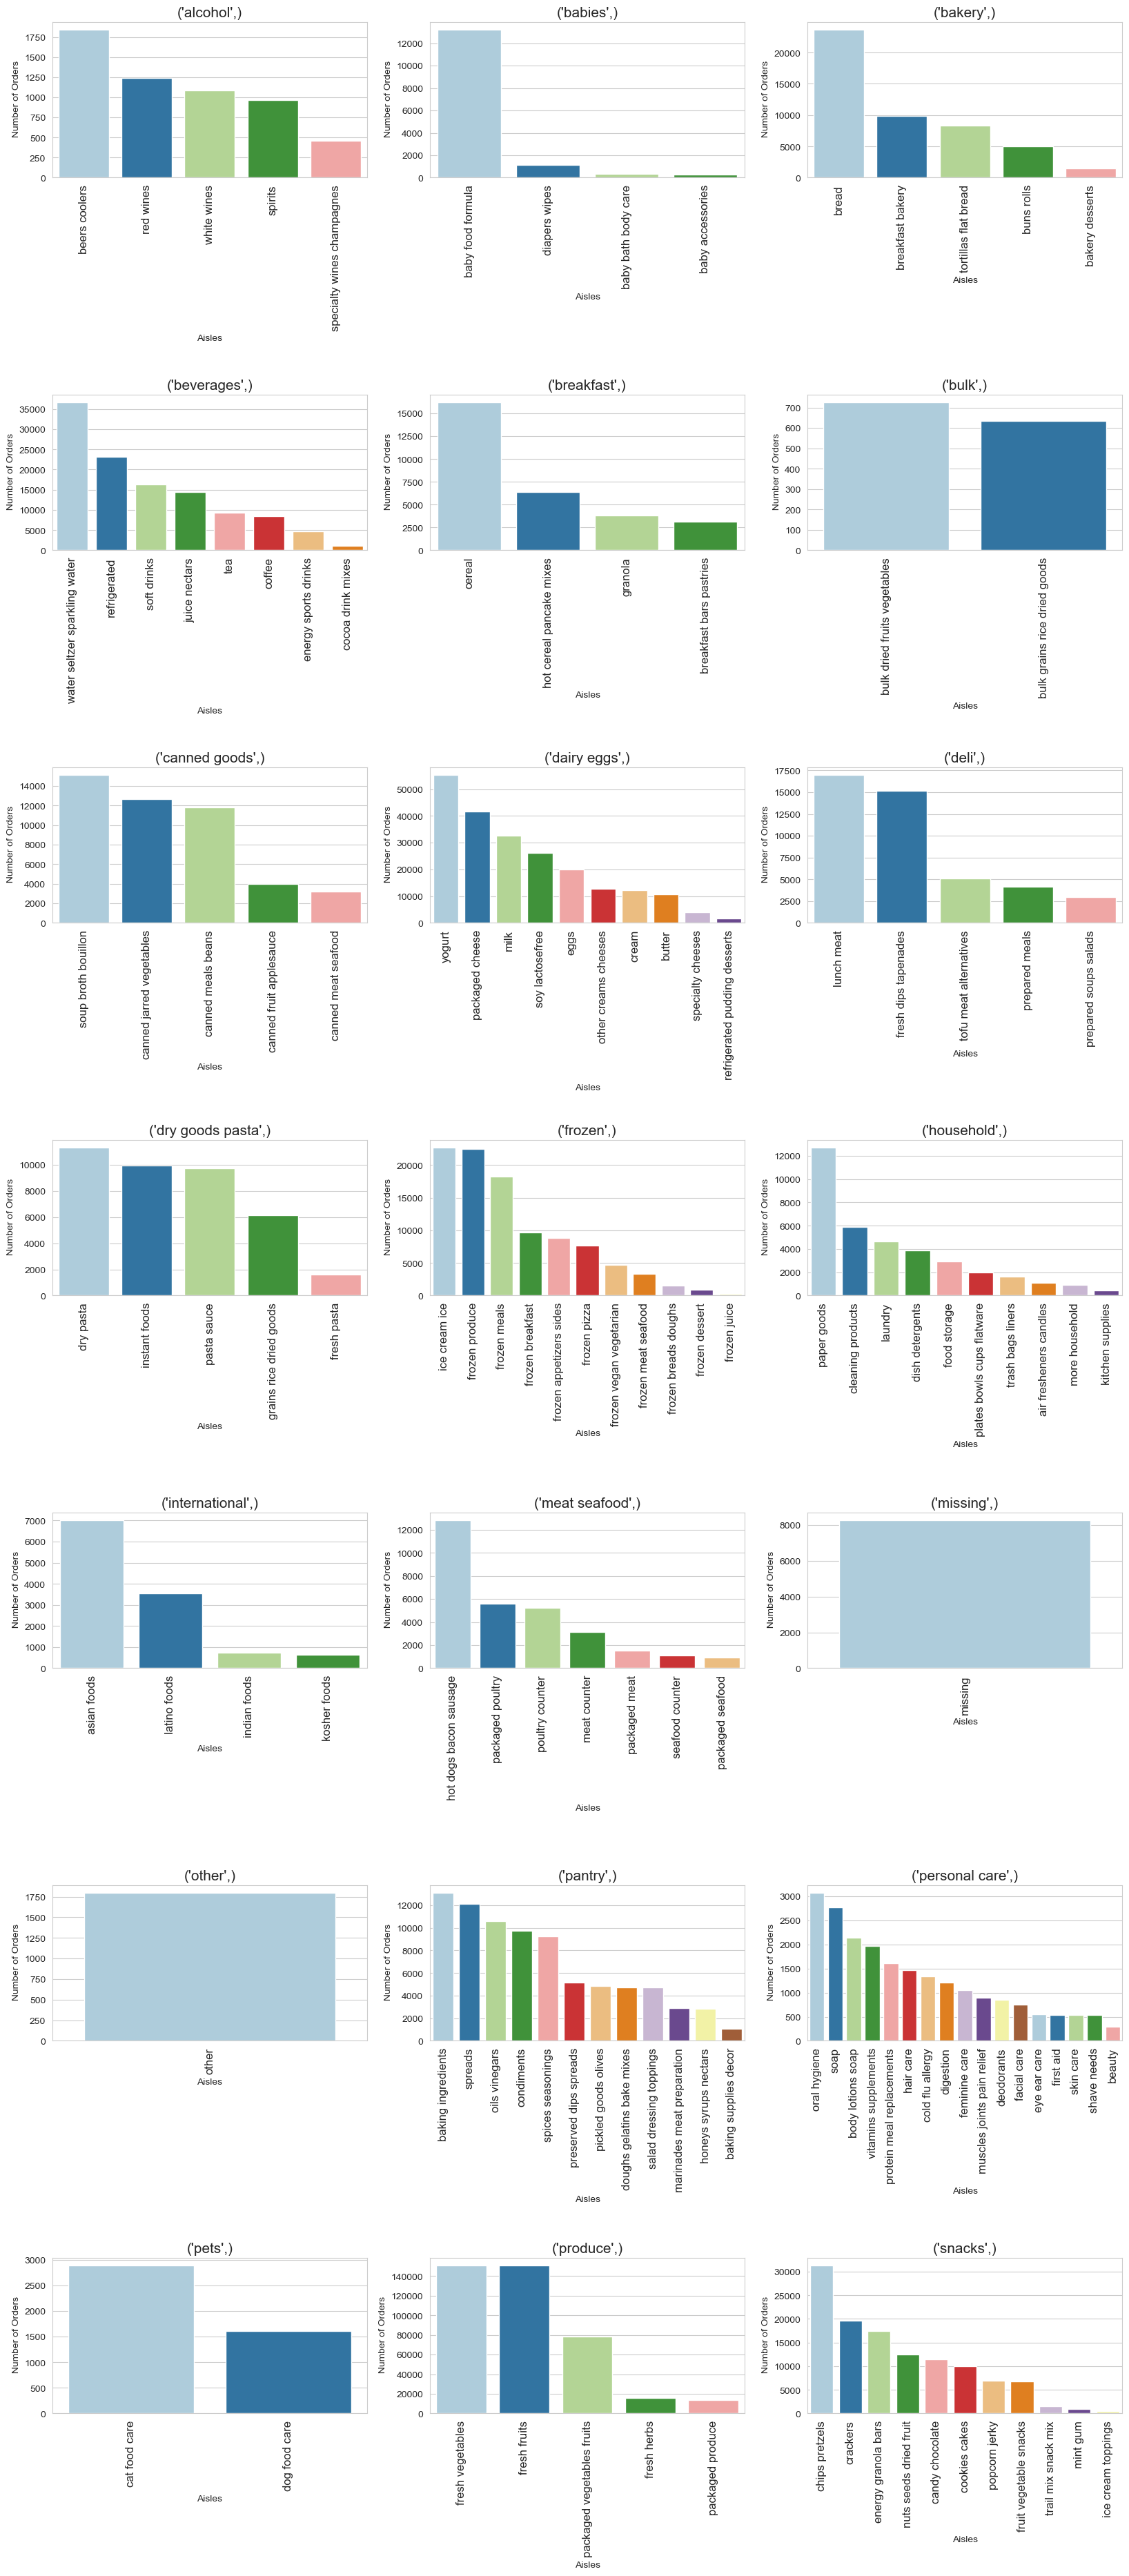

In [78]:
#Best Selling Aisles in each Department (number of Orders)
grouped = users_flow.groupby(["department", "aisle"])["order_id"].aggregate(['count']).reset_index()
grouped= grouped.rename(columns={'count': 'Total_orders'})
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(x=group.aisle, y=group.Total_orders , ax=ax, palette='Paired')
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)


In [80]:
#Best Selling Aisles over all Departments.¶
grouped = users_flow.groupby("aisle")["order_id"].aggregate(['count']).reset_index()
grouped = grouped.rename(columns={'count': 'Total_orders'})                                                        
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.108773
50,fresh fruits,150473,0.108675
98,packaged vegetables fruits,78493,0.056689
133,yogurt,55240,0.039896
93,packaged cheese,41699,0.030116
131,water seltzer sparkling water,36617,0.026446
83,milk,32644,0.023576
25,chips pretzels,31269,0.022583
119,soy lactosefree,26240,0.018951
11,bread,23635,0.017070


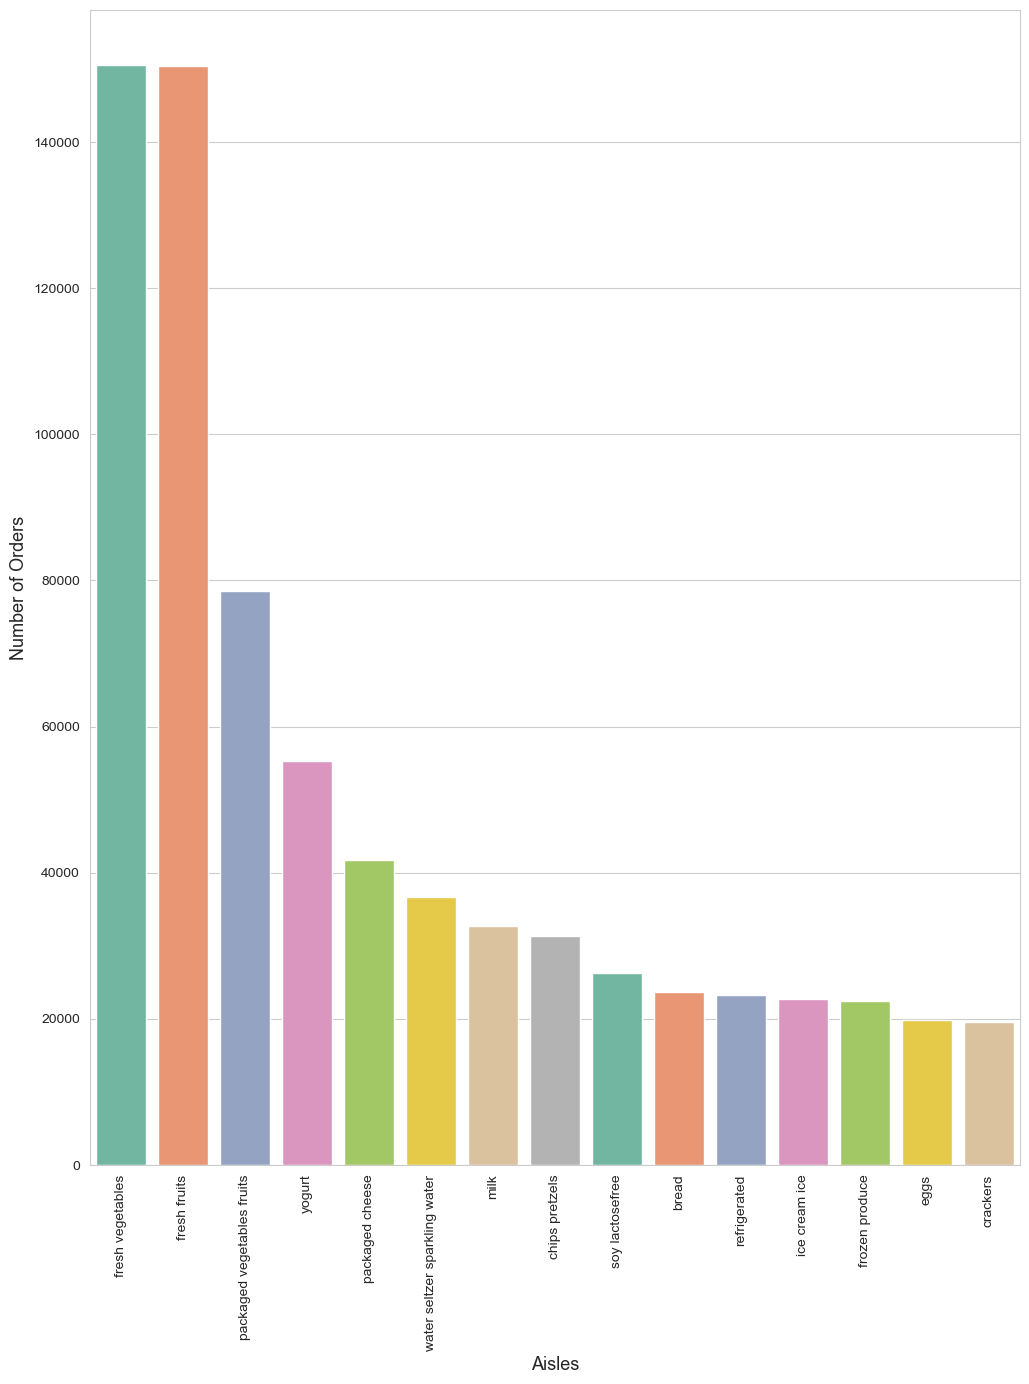

In [81]:
grouped  = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index,y= grouped.values,palette='Set2')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()